# Define Train and Validate the models

This notebook takes the normalized csv files and uses TF with kernals to build a predictor for a virtul water level sensor.

In [1]:
# leave until I can determine if tensorboard runs in ibm cloud
# %load_ext tensorboard.notebook

In [2]:
import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import os.path


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
print(tf.__version__)

2.13.0


In [4]:
# TODO: This code needs to read the normalized csv files into dataframes directly

In [5]:
# The current directory will be where this src file is located.
# Which is in the src dir of the project
dirpath = os.getcwd()
print("current directory is : " + dirpath)

current directory is : /Users/davis/progs/ccivm/src


In [6]:
root_path = os.path.dirname(dirpath)
print("parent directory is : " + root_path)

parent directory is : /Users/davis/progs/ccivm


In [7]:
data_path = root_path + "/data"
print("data_path is : " + data_path)

data_path is : /Users/davis/progs/ccivm/data


In [8]:
logs_path = os.path.join(root_path,"logs")
print("logs directory is : " + logs_path)

logs directory is : /Users/davis/progs/ccivm/logs


In [18]:
LOG_DIR_NAME = logs_path
os.environ['LOG_DIR_NAME'] = LOG_DIR_NAME

train_csv = data_path + "/train.csv"
test_csv = data_path + "/test.csv"
valid_csv = data_path + "/valid.csv"
os.environ['CSV_FILE_NAME'] = data_path + "/train.csv"

In [19]:
%%bash
echo ${LOG_DIR_NAME}

/Users/davis/progs/ccivm/logs


In [20]:
%%bash
head ${CSV_FILE_NAME}

tidal_high,tidal_low,precipitation_inches,lat,long,date_year,date_month,date_day
-0.7106445429067397,0.8374359273625821,-0.8382351786640309,-1.7149176840934133,0.966205669600699,-0.4599858421420725,1.0838355713092984,0.36725924244892283
-0.8662002982745587,0.9587372318349447,-0.0311074742187127,-1.2626461956311819,0.92024609467606,1.5409091489755415,-0.9007352840581362,-0.7642803331091387
0.0005563706349289259,1.3709516214921078,1.3830154520982887,-1.7149176840934133,0.966205669600699,-0.4599858421420725,-0.6172251618627884,-1.2168961633323632
-0.1416838120734048,0.0075226253833193145,-0.0311074742187127,0.3574499873246819,0.16278355491507135,0.5404616534167345,0.23330520472325506,1.6119527755627905
0.3502301531262494,-0.6445521118861014,-0.2884206660991002,0.49461998232764226,0.9531489721789501,0.5404616534167345,1.6508558156999942,1.6119527755627905
0.4094968959213884,0.40765939598046386,-0.266428085596503,0.5318760303533262,-0.9302070937022114,0.5404616534167345,1.6508558156999942,0

In [21]:
%%bash
# this csv file has 9875 lines corresponding to records (plus one header row)
wc -l ${CSV_FILE_NAME}

    6913 /Users/davis/progs/ccivm/data/train.csv


# Use generic python to read data into pandas dataframe

In [22]:
# Read the csv files into the new datasets
normed_train_ds = pd.read_csv(train_csv, 
                          header=0,
                          sep=",")

In [23]:
# Read the csv files into the new datasets
normed_valid_ds = pd.read_csv(valid_csv, 
                          header=0,
                          sep=",")

In [24]:
# Read the csv files into the new datasets
normed_test_ds = pd.read_csv(test_csv, 
                          header=0,
                          sep=",")

In [37]:
# Create seperate series/dataframe? for labels
# Remove the label from the dataframes.
train_labels = normed_train_ds.pop('tidal_high')
test_labels = normed_test_ds.pop('tidal_high')
valid_labels = normed_valid_ds.pop('tidal_high')

# Build the model

In [38]:
# train_ds determines the input feature size
model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(normed_train_ds.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
    ])

# orig
#optimizer = tf.keras.optimizers.RMSprop(0.001)
# increase learning rate if fairly consistent but slow changing
#optimizer = tf.keras.optimizers.RMSprop(0.01)
# 0.1 is too big
#optimizer = tf.keras.optimizers.RMSprop(0.1)
# with the early stop, lets try to make the learning rate smaller
optimizer = tf.keras.optimizers.RMSprop(0.0001)

# Add in the early stop code
# The patience parameter is the amount of epochs to check for improvement
#
# NOTE: This was a good addition.  I'm so used to running through a lot of steps
# I did not realize that it was finding its best results so early.  In the 
# graphs that follows, you can see the divergent graphs here where the others
# did not show it since it was hundreds of epochs past optimal.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)



model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mean_absolute_error', 'mean_squared_error'])


# Train the model (with three callbacks)

In [26]:
EPOCHS = 1000

In [27]:
%%bash
# clear any logs from previous runs
rm -rf ${LOG_DIR_NAME}

In [28]:
logdir = os.path.join(LOG_DIR_NAME, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
print(logdir)

/Users/davis/progs/ccivm/logs/20230913-142742


In [29]:
os.environ['LOG_DIR_NAME_TIME_VARIABLE'] = logdir

In [39]:
# cell magic is weird on how to evaluate this
# this works since its hard coded but not time variable
#%tensorboard --logdir '/home/davis/progs/tf-hackathon/logs'
# ps auxw | grep tensorboard show this as literal --logdir logdir
#%tensorboard --logdir logdir
# ps auxw | grep tensorboard show this as literal --logdir $/home/davis/....
#%tensorboard --logdir ${LOG_DIR_NAME}
# ps auxw | grep tensorboard show this as literal --logdir /home/davis/...
# this works because it finds tf events in root down
#%tensorboard --logdir {LOG_DIR_NAME}
# this does not work.  ps auxw shows tensorboard --logdir {LOG_DIR_NAME_TIME_VARIABLE}
#%tensorboard --logdir {LOG_DIR_NAME_TIME_VARIABLE}
# this works best. it shows up in tensorboard with time variable. tensorboard --logdir /home/davis/progs/tf-hackathon/logs/20190506-115136
#%tensorboard --logdir {logdir}

Wait a bit until the above pane shows the blank tensorboard page before running the cell below

In [40]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [41]:
#                    batch_size=16,

history = model.fit(normed_train_ds, 
                    train_labels,
                    epochs=EPOCHS,
                    validation_data = (normed_valid_ds, valid_labels),
                    verbose=0,
                    callbacks=[early_stop, tensorboard_callback, PrintDot()])


....................................................................................................
................................................................................................

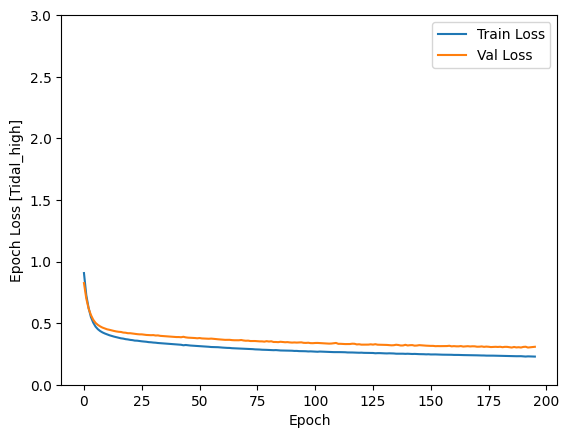

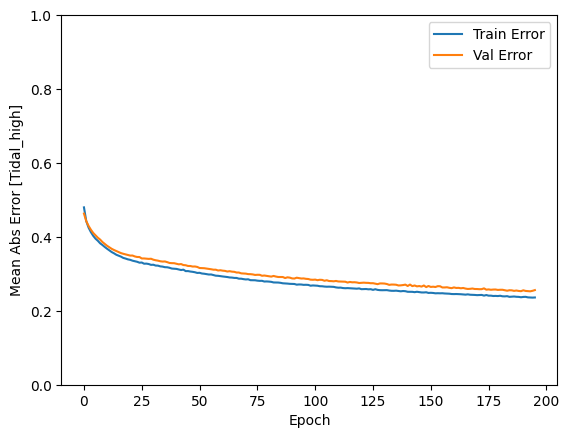

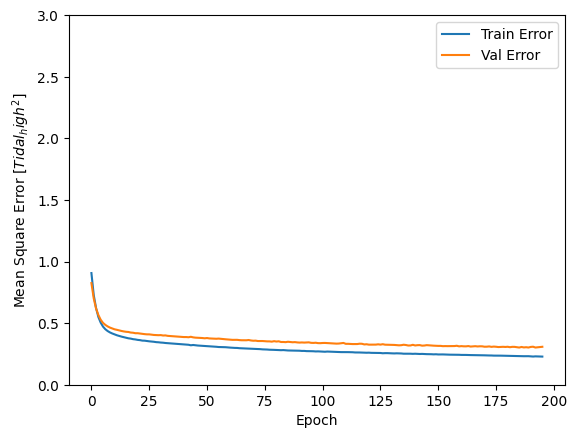

In [42]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch


    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Epoch Loss [Tidal_high]')
    plt.plot(hist['epoch'], hist['loss'],label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Val Loss')
    plt.ylim([0,3])
    plt.legend()


    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Tidal_high]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$Tidal_high^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],label = 'Val Error')
    plt.ylim([0,3])
    plt.legend()
    plt.show()


plot_history(history)

In [43]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

In [44]:
hist

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
0,0.906331,0.479849,0.906331,0.825018,0.462961,0.825018,0
1,0.727756,0.442443,0.727756,0.700384,0.442542,0.700384,1
2,0.623290,0.424996,0.623290,0.618817,0.429610,0.618817,2
3,0.549750,0.412865,0.549750,0.566064,0.419292,0.566064,3
4,0.504266,0.402906,0.504266,0.527634,0.410644,0.527634,4
...,...,...,...,...,...,...,...
191,0.228758,0.237811,0.228758,0.308380,0.253772,0.308380,191
192,0.230255,0.236332,0.230255,0.301912,0.253128,0.301912,192
193,0.230023,0.236059,0.230023,0.304068,0.252722,0.304068,193
194,0.229030,0.235700,0.229030,0.305518,0.254107,0.305518,194


Now we are getting reasonable results.  Using a smaller learning rate, with an early stop callback.

# Evauate model
Note by including the data with missing values and adding in average amounts increased the error.

In [45]:
loss, mae, mse = model.evaluate(normed_test_ds, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} predicted water level high in feet".format(mae))

Testing set Mean Abs Error:  0.24 predicted water level high in feet


# Make predictions

47/47 [==============================] - 0s 267us/step


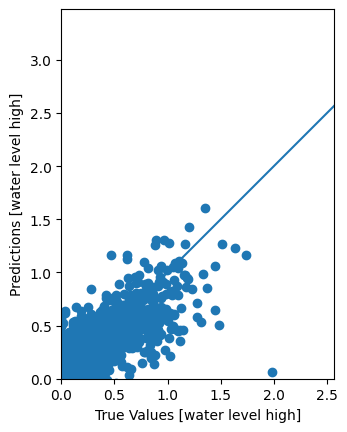

In [46]:
test_predictions = model.predict(normed_test_ds).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [water level high]')
plt.ylabel('Predictions [water level high]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Look at error distribution

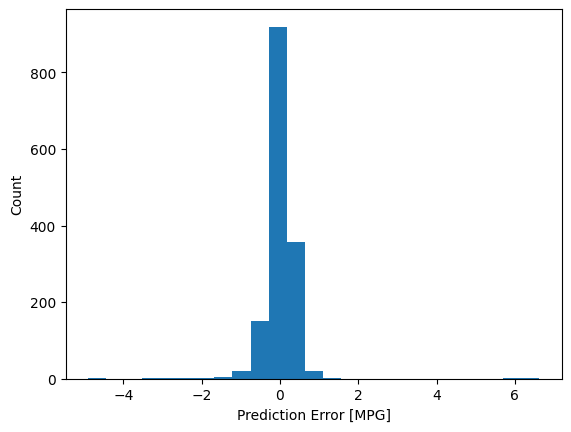

In [47]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")